Baseline model for classifying GitHub README's into a single NAICS category based on the highest cosine similarity between README TF-IDF vector and NAICS category description TF-IDF vectors.

In [18]:
import pandas as pd
import os
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


In [19]:
import markdown # pip install markdown
from bs4 import BeautifulSoup # pip install beautifulsoup4


In [55]:
data_path = "../feature_extraction"
naics = pd.read_csv(data_path+"/NAICS descriptions.csv")
map = zip(naics["Sector"], naics["Definition"])
naics = naics.drop([18])
naics

,Sector,Definition,Descriptions
0,11,"Agriculture, Forestry, Fishing and Hunting","The Agriculture, Forestry, Fishing and Hunting..."
1,21,"Mining, Quarrying, and Oil and Gas Extraction","The Mining, Quarrying, and Oil and Gas Extract..."
2,22,Utilities,The Utilities sector comprises establishments ...
3,23,Construction,The Construction sector comprises establishmen...
4,31-33,Manufacturing,The Manufacturing sector comprises establishme...
5,42,Wholesale Trade,The Wholesale Trade sector comprises establish...
6,44-45,Retail Trade,The Retail Trade sector comprises establishmen...
7,48-49,Transportation and Warehousing,The Transportation and Warehousing sector incl...
8,51,Information,The Information sector comprises establishment...
9,52,Finance and Insurance,The Finance and Insurance sector comprises est...


In [56]:
def md_to_text(md):
    html = markdown.markdown(md)
    soup = BeautifulSoup(html, features='html.parser')
    return soup.get_text()

In [57]:
import pandas as pd
import re
import numpy as np
def clean_readme(text):
    if isinstance(text, str):
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove Markdown image tags (![...](...))
        text = re.sub(r'!\[.*?\]\(.*?\)', '', text)

        # Remove Markdown links ([...](...))
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)

        if len(text) < 5:
          return np.nan

        return text
    else:
        # Handle cases where the input is not a string (e.g., None)
        return ""

In [58]:
# data_path = "/content/drive/MyDrive/[Fall 23] DC-Github/Models/"
# os.chdir(data_path)
corpus = pd.read_csv(data_path+"/Testing corpus.csv")
corpus = corpus.dropna()
corpus["Text"] = corpus["Text"].apply(md_to_text).str.replace('\n', '')
corpus['Text'] = corpus['Text'].apply(clean_readme)
corpus['Length'] = [len(x.split()) for x in corpus['Text'].tolist()]
corpus


,Sector,Text,Length
0,11,Awesome Agriculture A curated list of awesome ...,849
1,11,farmOSfarmOS is a web-based application for fa...,215
2,11,End Official Support and Maintenance for Tania...,252
3,11,FarmVibes.AI: Multi-Modal GeoSpatial ML Models...,1240
4,11,AgroChainThis repository contains the code for...,1004
...,...,...,...
87,72,The-CookbookThe open source cook bookAlso take...,73
88,92,"""Public Administration Blockchain Certified Do...",261
89,92,"""ServiceAgent:innenThis repository contains th...",797
90,92,Report.itReport.it supports those who have bee...,75


In [59]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# TF-IDF vectorization for the NAICS descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(naics['Descriptions'])

In [60]:
# Function to find the closest NAICS topic using cosine distance
def find_closest_topic_cosine(readme_text):
    # TF-IDF vectorization for the GitHub README
    readme_tfidf = tfidf_vectorizer.transform([readme_text])
    # print(readme_tfidf.shape)

    # Calculate cosine similarity between the README and each NAICS topic
    similarities = cosine_similarity(readme_tfidf, tfidf_matrix)

    # Find the topic with the highest similarity
    # print(similarities)
    closest_topic_index = similarities.argmax()
    closest_topic = naics['Sector'].iloc[closest_topic_index]
    closest_topic_label = naics[naics["Sector"] == closest_topic]["Definition"]

    return closest_topic



In [61]:
# Function to find the closest NAICS topic using euclidean distance
def find_closest_topic_euclidean(readme_text):
    # TF-IDF vectorization for the GitHub README
    readme_tfidf = tfidf_vectorizer.transform([readme_text])

    # Calculate cosine similarity between the README and each NAICS topic
    similarities = cosine_similarity(readme_tfidf, tfidf_matrix)

    # Find the topic with the highest similarity
    # print(similarities)
    closest_topic_index = similarities.argmax()
    closest_topic = naics['Sector'].iloc[closest_topic_index]
    closest_topic_label = naics[naics["Sector"] == closest_topic]["Definition"]

    return closest_topic

In [62]:
corpus['TFIDF Cosine'] = corpus['Text'].apply(find_closest_topic_cosine)

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Calculate accuracy
accuracy = accuracy_score(corpus['Sector'], corpus['TFIDF Cosine'])
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(corpus['Sector'], corpus['TFIDF Cosine'], average="macro")
print("Precision:", precision)


# Calculate recall
recall = recall_score(corpus['Sector'], corpus['TFIDF Cosine'], average="macro")
print("Recall:", recall)



Accuracy: 0.18478260869565216
Precision: 0.32982456140350874
Recall: 0.1956140350877193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
corpus['TFIDF Euclidean'] = corpus['Text'].apply(find_closest_topic_euclidean)
# Calculate accuracy
accuracy = accuracy_score(corpus['Sector'], corpus['TFIDF Euclidean'])
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(corpus['Sector'], corpus['TFIDF Euclidean'], average="macro")
print("Precision:", precision)


# Calculate recall
recall = recall_score(corpus['Sector'], corpus['TFIDF Euclidean'], average="macro")
print("Recall:", recall)

Accuracy: 0.18478260869565216
Precision: 0.32982456140350874
Recall: 0.1956140350877193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
misclassified = corpus[corpus["Sector"]!=corpus["TFIDF Cosine"]]
misclassified

,Sector,Text,Length,TFIDF Cosine,TFIDF Euclidean
0,11,Awesome Agriculture A curated list of awesome ...,849,51,51
1,11,farmOSfarmOS is a web-based application for fa...,215,52,52
2,11,End Official Support and Maintenance for Tania...,252,52,52
3,11,FarmVibes.AI: Multi-Modal GeoSpatial ML Models...,1240,52,52
4,11,AgroChainThis repository contains the code for...,1004,51,51
...,...,...,...,...,...
85,72,"""# Sharing Excess Food Rescue AppWelcome to th...",965,52,52
87,72,The-CookbookThe open source cook bookAlso take...,73,52,52
89,92,"""ServiceAgent:innenThis repository contains th...",797,52,52
90,92,Report.itReport.it supports those who have bee...,75,51,51


In [ ]:
misclassified["Length"].value_counts(bins = [0,100, 500, 1000, 2000])

(100.0, 500.0]      32
(500.0, 1000.0]     23
(1000.0, 2000.0]     9
(-0.001, 100.0]      7
Name: Length, dtype: int64

In [ ]:
correct = corpus[corpus["Sector"]==corpus["TFIDF Cosine"]]
correct["Length"].value_counts(bins = [0,100, 500, 1000, 2000])

(100.0, 500.0]      10
(-0.001, 100.0]      4
(500.0, 1000.0]      2
(1000.0, 2000.0]     1
Name: Length, dtype: int64

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns



In [ ]:
test_class = naics['Sector']
test_true = corpus['Sector']
test_pred = corpus['TFIDF Cosine']
# # confusion_matrix(test_true, test_pred, test_class)
# cm = confusion_matrix(test_true, test_pred, test_class)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class)

Text(0.5, 23.52222222222222, 'Predicted')

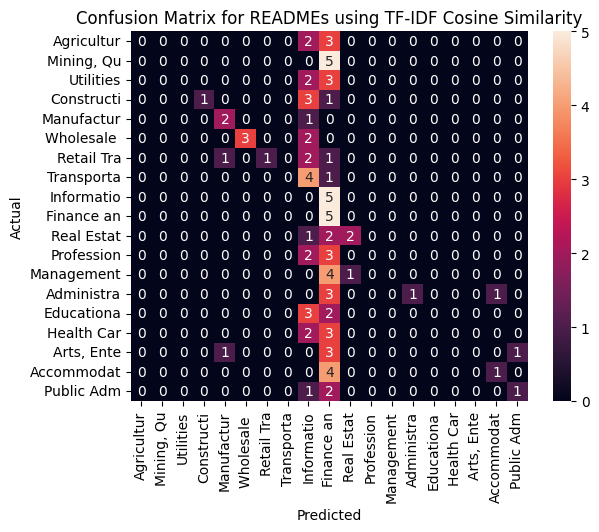

In [ ]:
truncated = [i[0:10] for i in naics['Definition']]
plt.figure()
cf= confusion_matrix(test_true, test_pred, labels=naics['Sector'])
cm_df = pd.DataFrame(cf, index=truncated, columns=truncated)
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for READMEs using TF-IDF Cosine Similarity')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
import pandas as pd
import numpy as np

labels = ['11', '21', '22', '23', '31-33', '42', '44-45', '48-49', '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '92']

columns = labels
df = pd.DataFrame(columns=columns)

for i, sample_prediction in enumerate(test_pred.values):
    row = [0] * len(labels)

    if sample_prediction in labels:
        row[columns.index(sample_prediction)] = 1

    df.loc[i] = row

predicted_labels = df

import pandas as pd

true_labels = test_true

data = {
    "true_labels": true_labels
}

df = pd.DataFrame(data)

unique_labels = df["true_labels"].unique()

true_labels_encoded = pd.get_dummies(df["true_labels"])

value_to_append = 0

zeros_to_append = np.zeros((true_labels_encoded.values.shape[0], 1))

true_labels = np.hstack((true_labels_encoded.values, zeros_to_append))
true_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


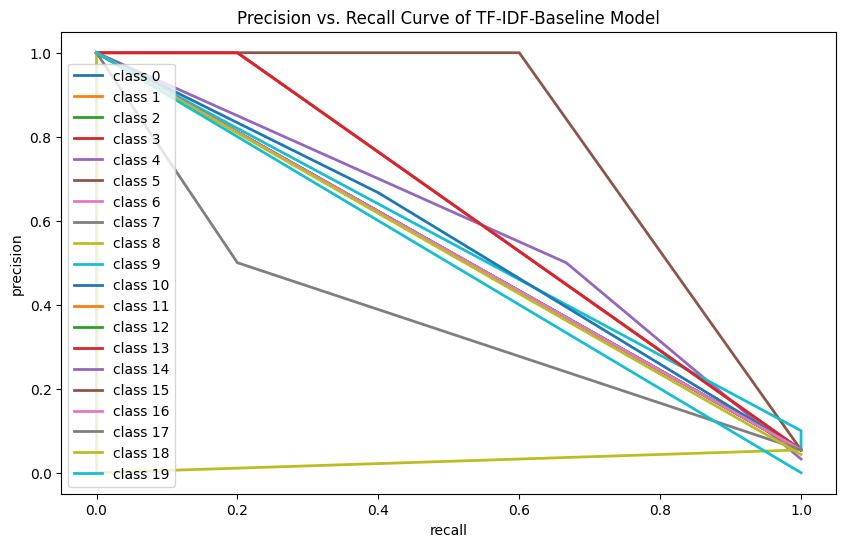

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(figsize=(10, 6))
num_classes = 20
precision = {}
recall = {}
thresholds = {}

for class_index in range(num_classes):
    precision[class_index], recall[class_index], thresholds[class_index] = precision_recall_curve(
        true_labels[:, class_index], predicted_labels.values[:, class_index])

    ax.plot(recall[class_index], precision[class_index], lw=2, label='class {}'.format(class_index))

ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.legend(loc="best")
ax.set_title("Precision vs. Recall Curve of TF-IDF-Baseline Model")

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


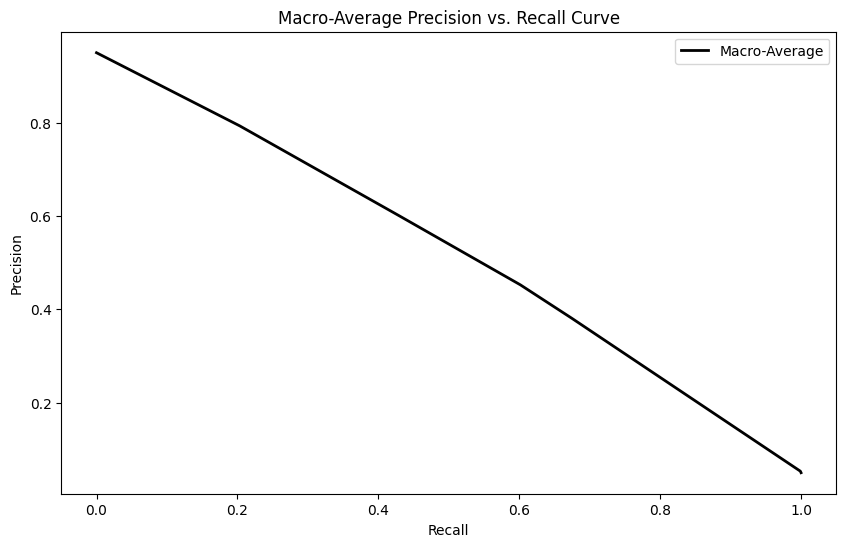

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(figsize=(10, 6))
num_classes = 20

precision = {}
recall = {}
thresholds = {}

all_precision = []
all_recall = []

common_thresholds = np.linspace(0, 1, 1000)

for class_index in range(num_classes):
    class_precision, class_recall, _ = precision_recall_curve(
        true_labels[:, class_index], predicted_labels.values[:, class_index])
    interpolated_precision = np.interp(common_thresholds, class_recall[::-1], class_precision[::-1])

    all_precision.append(interpolated_precision)
    all_recall.append(common_thresholds)

macro_avg_precision = np.mean(all_precision, axis=0)
macro_avg_recall = np.mean(all_recall, axis=0)

ax.plot(macro_avg_recall, macro_avg_precision, lw=2, label='Macro-Average', color='black')

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="best")
ax.set_title("Macro-Average Precision vs. Recall Curve")

plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


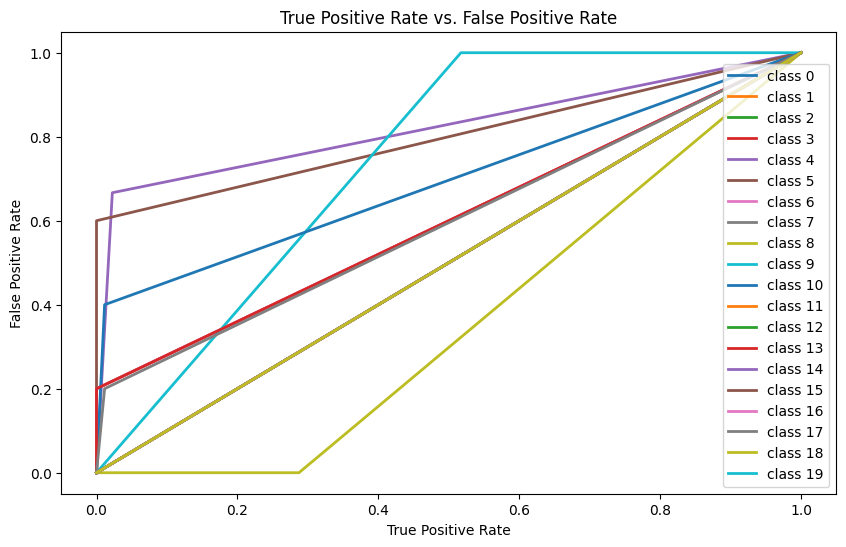

In [ ]:
# precision recall curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

precision = dict()
recall = dict()
fig, ax = plt.subplots(figsize=(10, 6))
num_classes = 20
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_labels.values[:, i])

    ax.plot(fpr, tpr, lw=2, label='class {}'.format(i))
    ax.set_xlabel("True Positive Rate")
    ax.set_ylabel("False Positive Rate")
    ax.legend(loc="best")
    ax.set_title("True Positive Rate vs. False Positive Rate")

plt.show()


TypeError: ignored

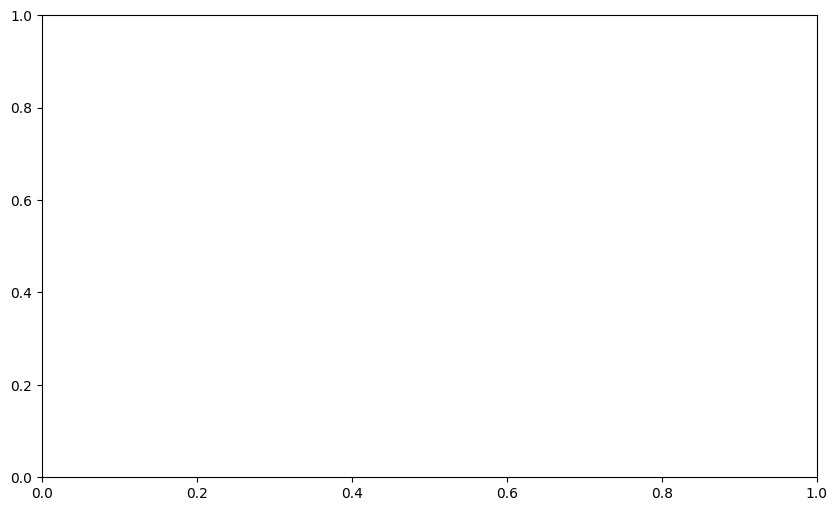

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(10, 6))
num_classes = 19

all_fpr = np.linspace(0, 1, 10)
fpr_list = []
tpr_list = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_labels.values[:, i], drop_intermediatebool=False)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    interpolated_tpr = np.interp(all_fpr, fpr, tpr)

mean_tpr = np.mean([np.interp(all_fpr, roc_curve(true_labels[:, i], predicted_labels.values[:, i])[0],
                             roc_curve(true_labels[:, i], predicted_labels.values[:, i])[1])
                   for i in range(num_classes)], axis=0)

ax.plot(all_fpr, mean_tpr, color='black', lw=2, label='Micro-Average')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="best")
ax.set_title("True Positive Rate vs. False Positive Rate")

plt.show()


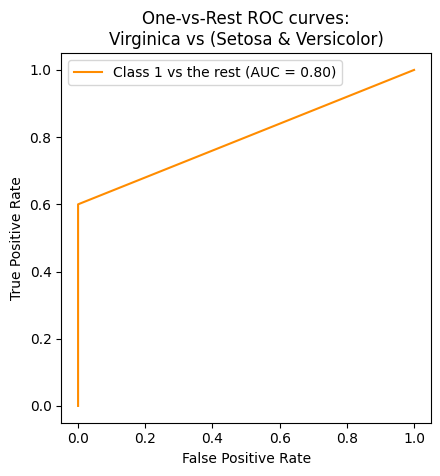

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    true_labels[:, 5],
    predicted_labels.values[:, 5],
    name=f"Class {1} vs the rest",
    color="darkorange",
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

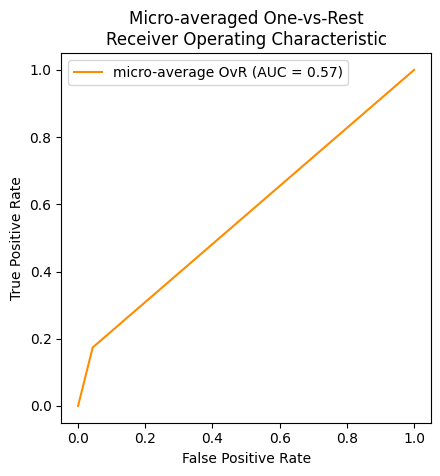

In [ ]:
RocCurveDisplay.from_predictions(
    true_labels.ravel(),
    predicted_labels.values.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()